### 回測參數設定
我們可以透過此 Python notebook ，使用不同參數進行回測。以下是各個參數的說明：

| 參數 | 位置 / 範例 | 用途  |
|------|------------|------|
| **horizons** | `horizons = [30, 60, 90]` | 想測試的所有回測週期，在這裡為存款開放期（天）。若以 60 為例，代表第 1 ~ 60 天允許 deposit，第 61 ~ 90 天只准 withdraw，確保所有 note 都能到期領回。 |
| **init_eths** | `init_eths = [10, 100]` | 池子啟動時放入的 ETH 數量。對應的 USDC 會依首日 ETH 價格自動計算，維持 50/50 配置。 |  
| **SCALES** | `SCALES = [1, 5, 10, 20, 50]` | **用戶下注切割倍率**：<br>‧ 每天投資筆數 × `scale`<br>‧ 每筆金額 ÷ `scale`<br>→ 模擬「把同樣資金拆成很多小單」以觀察滑價與 APR 收斂情況。 |  
| **BASIS** | `BASIS = 0.5` | Dyson Premium 的**基準利率**（0–1）。數值越高，投資人拿到的 premium 越多，池子負擔越大。 |  
| **W_FACTOR** | `W_FACTOR = 1` | 池子**目標權重**： `w = k × W_FACTOR`。影響 premium 折扣函式中累積流動性 `q/w` 的斜率，決定 premium 壓抑速度。 |  

目前主要測試的參數為回測週期、底池大小與用戶投注切割倍率，觀察用戶 PnL 與池子盈虧在不同參數下的變化。

========= 60d-100ETH-x1 (2025-02-03~2025-05-03) =========
info: {'start_date': datetime.date(2025, 2, 3), 'deposit_end_date': datetime.date(2025, 4, 4), 'total_end_date': datetime.date(2025, 5, 3), 'init_eth': 100, 'init_usdc': np.float64(286269.76188716287), 'MIN_ETH': 0.01, 'MAX_ETH': 0.5, 'MIN_USDC': 50, 'MAX_USDC': 2000, 'MAX_USERS': 10, 'BASIS': 0.5, 'W_FACTOR': 1, 'SCALE': 1, 'SEED': 42}
deposits:323  withdraws:323
User PnL Total: -14316.417074030218, 
 User PnL Average: -44.323272675016156
========= 60d-100ETH-x2 (2025-02-03~2025-05-03) =========
info: {'start_date': datetime.date(2025, 2, 3), 'deposit_end_date': datetime.date(2025, 4, 4), 'total_end_date': datetime.date(2025, 5, 3), 'init_eth': 100, 'init_usdc': np.float64(286269.76188716287), 'MIN_ETH': 0.01, 'MAX_ETH': 0.5, 'MIN_USDC': 50, 'MAX_USDC': 2000, 'MAX_USERS': 10, 'BASIS': 0.5, 'W_FACTOR': 1, 'SCALE': 2, 'SEED': 42}
deposits:708  withdraws:708
User PnL Total: -12924.296128495833, 
 User PnL Average: -18.254655548722

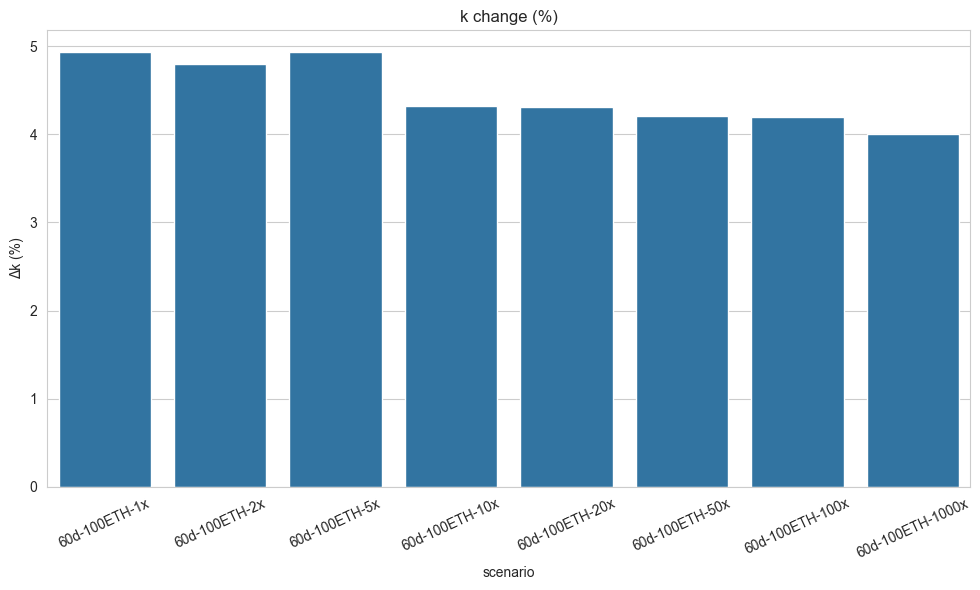

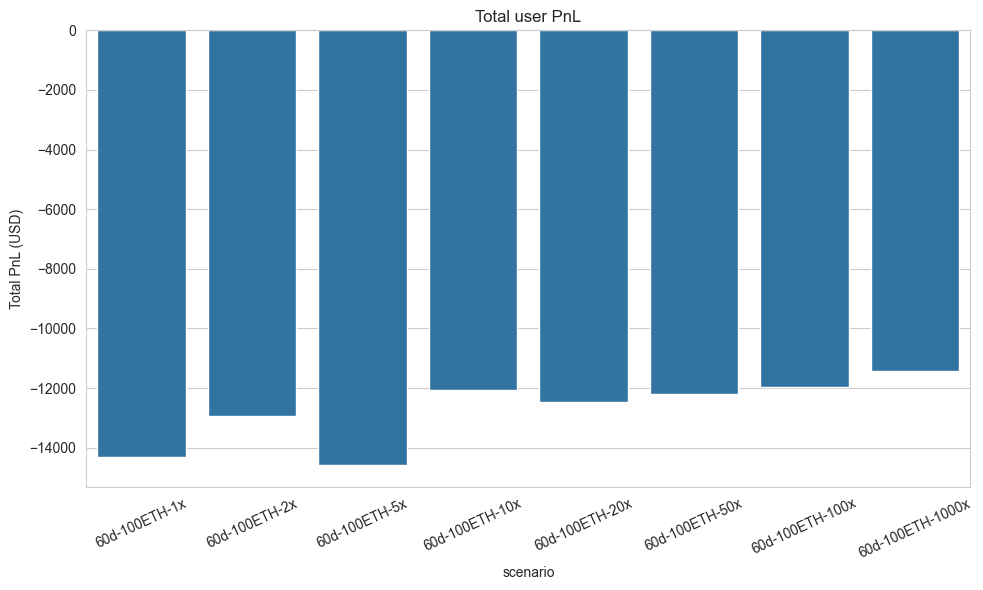

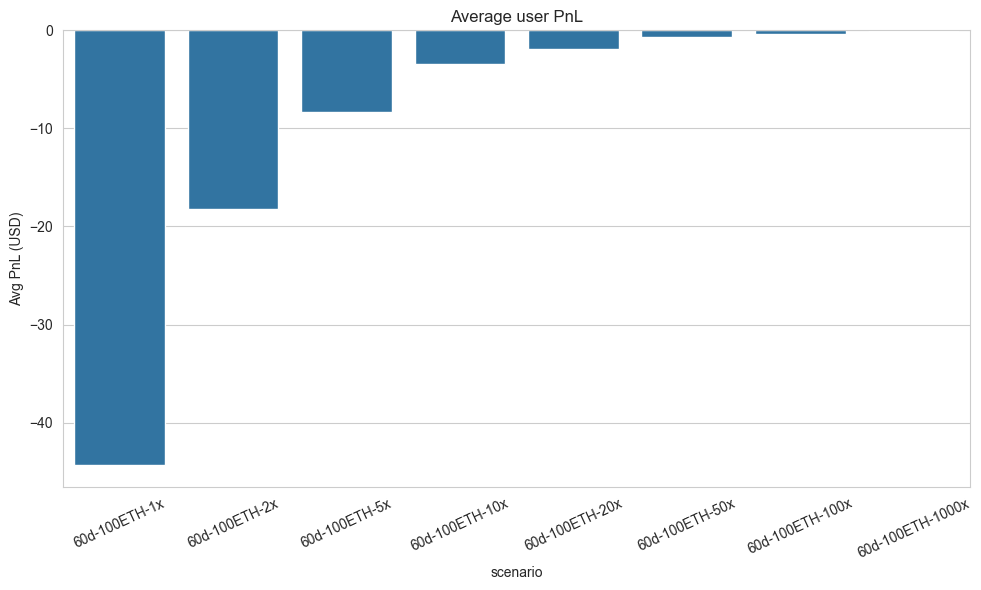

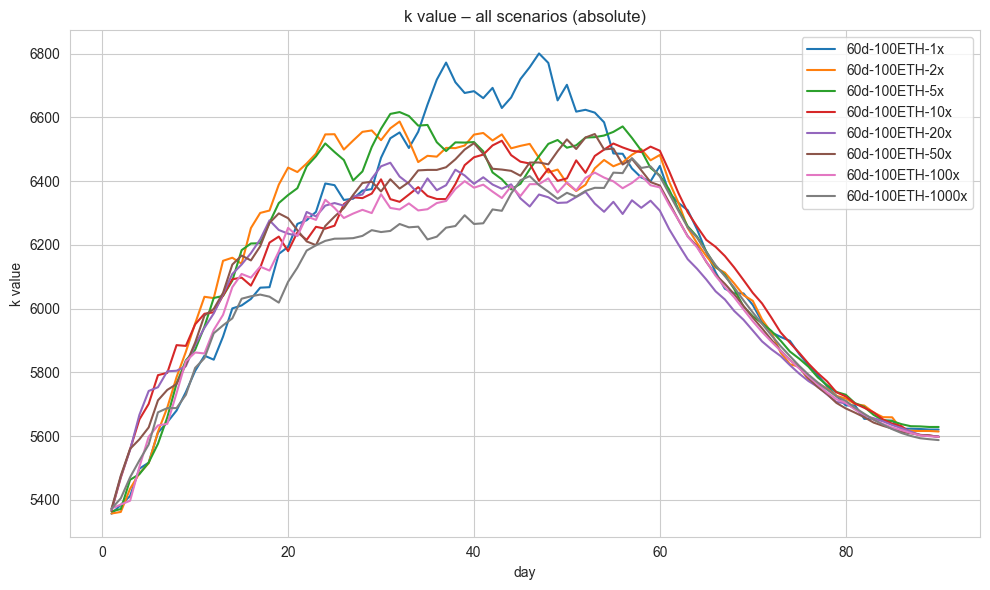

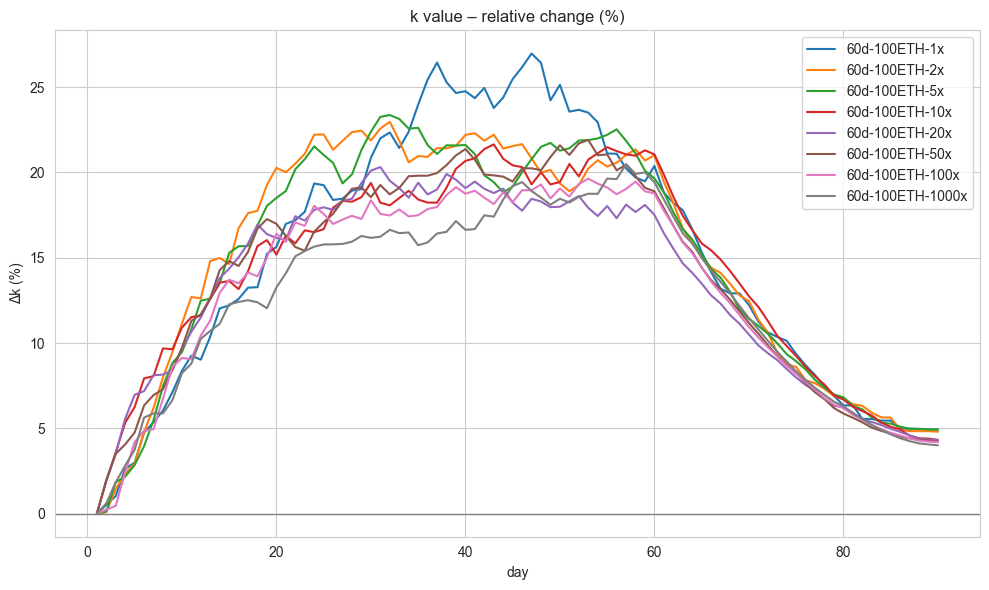

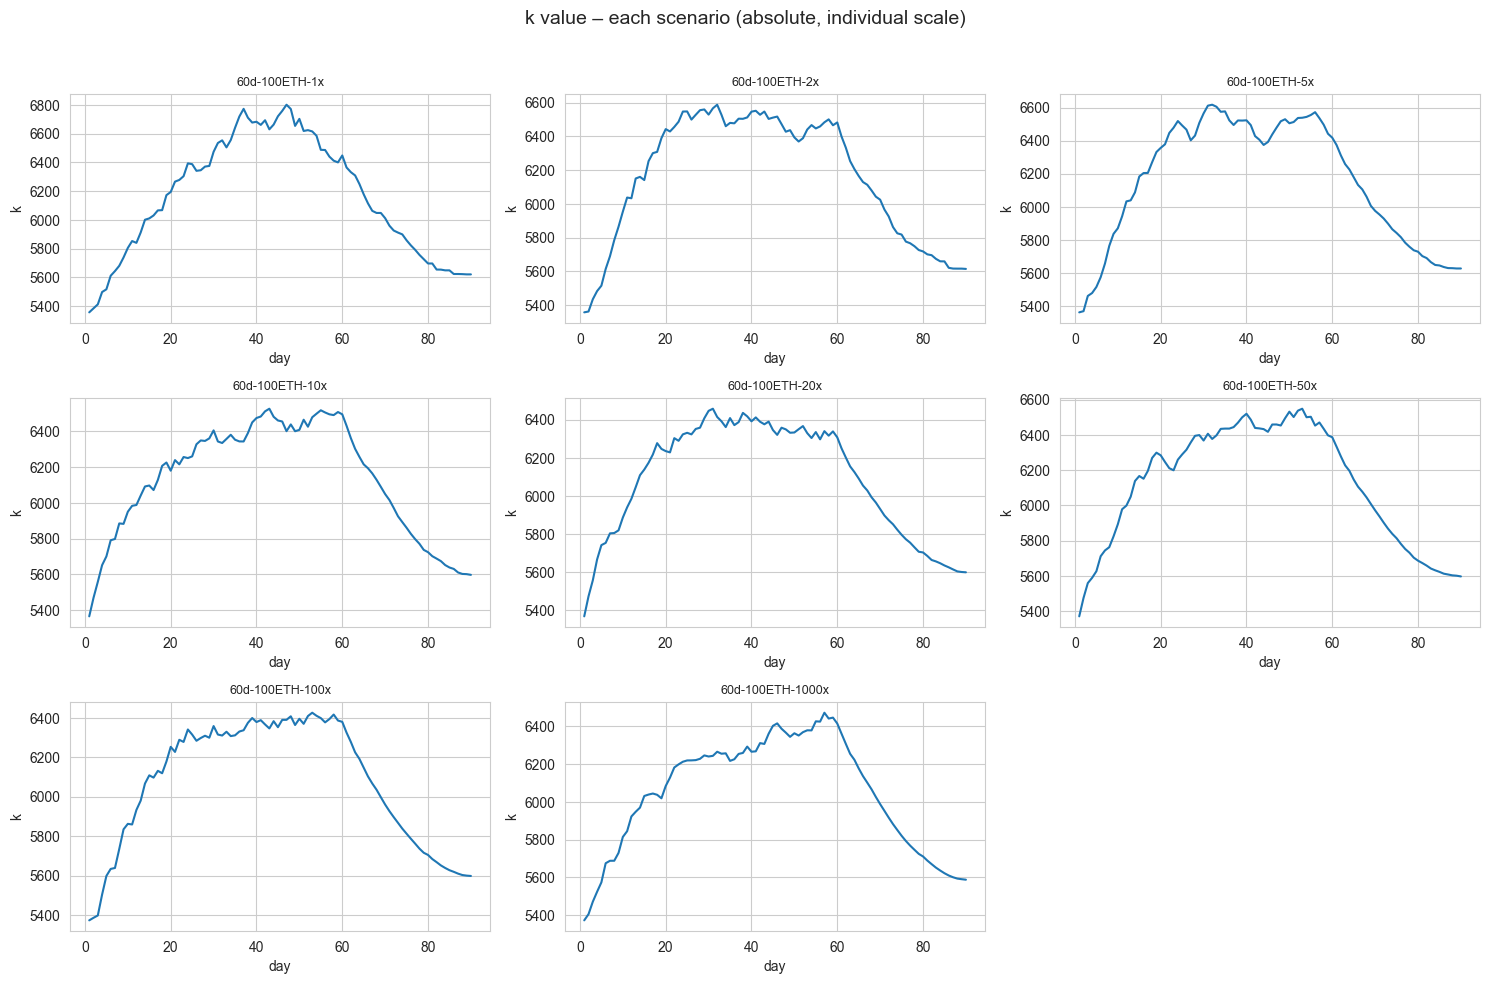

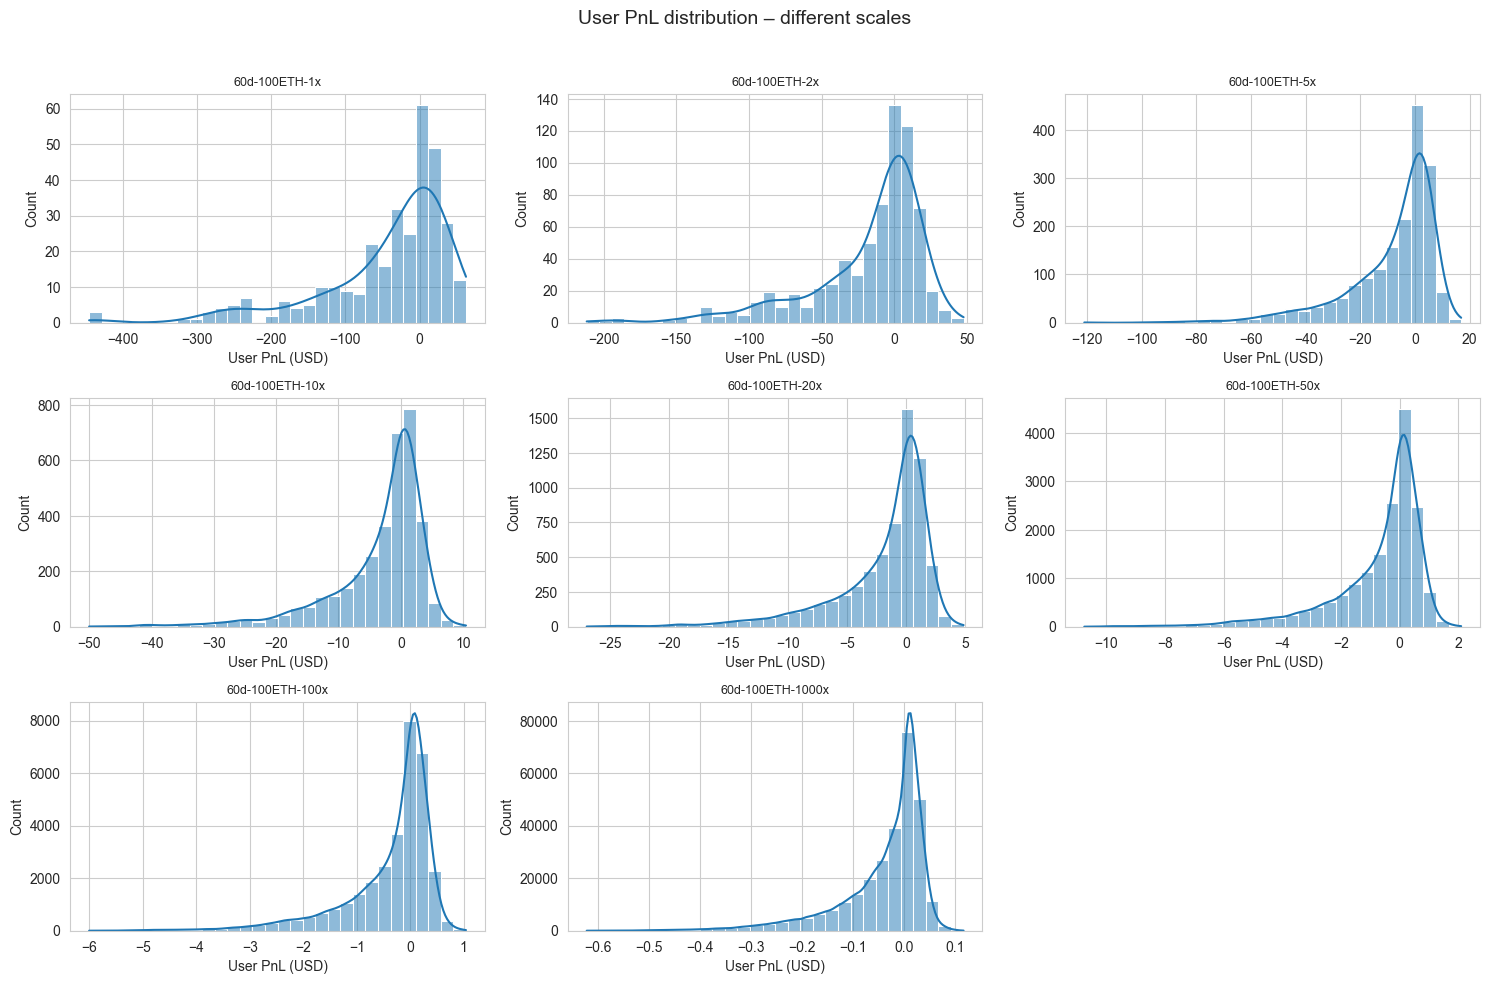

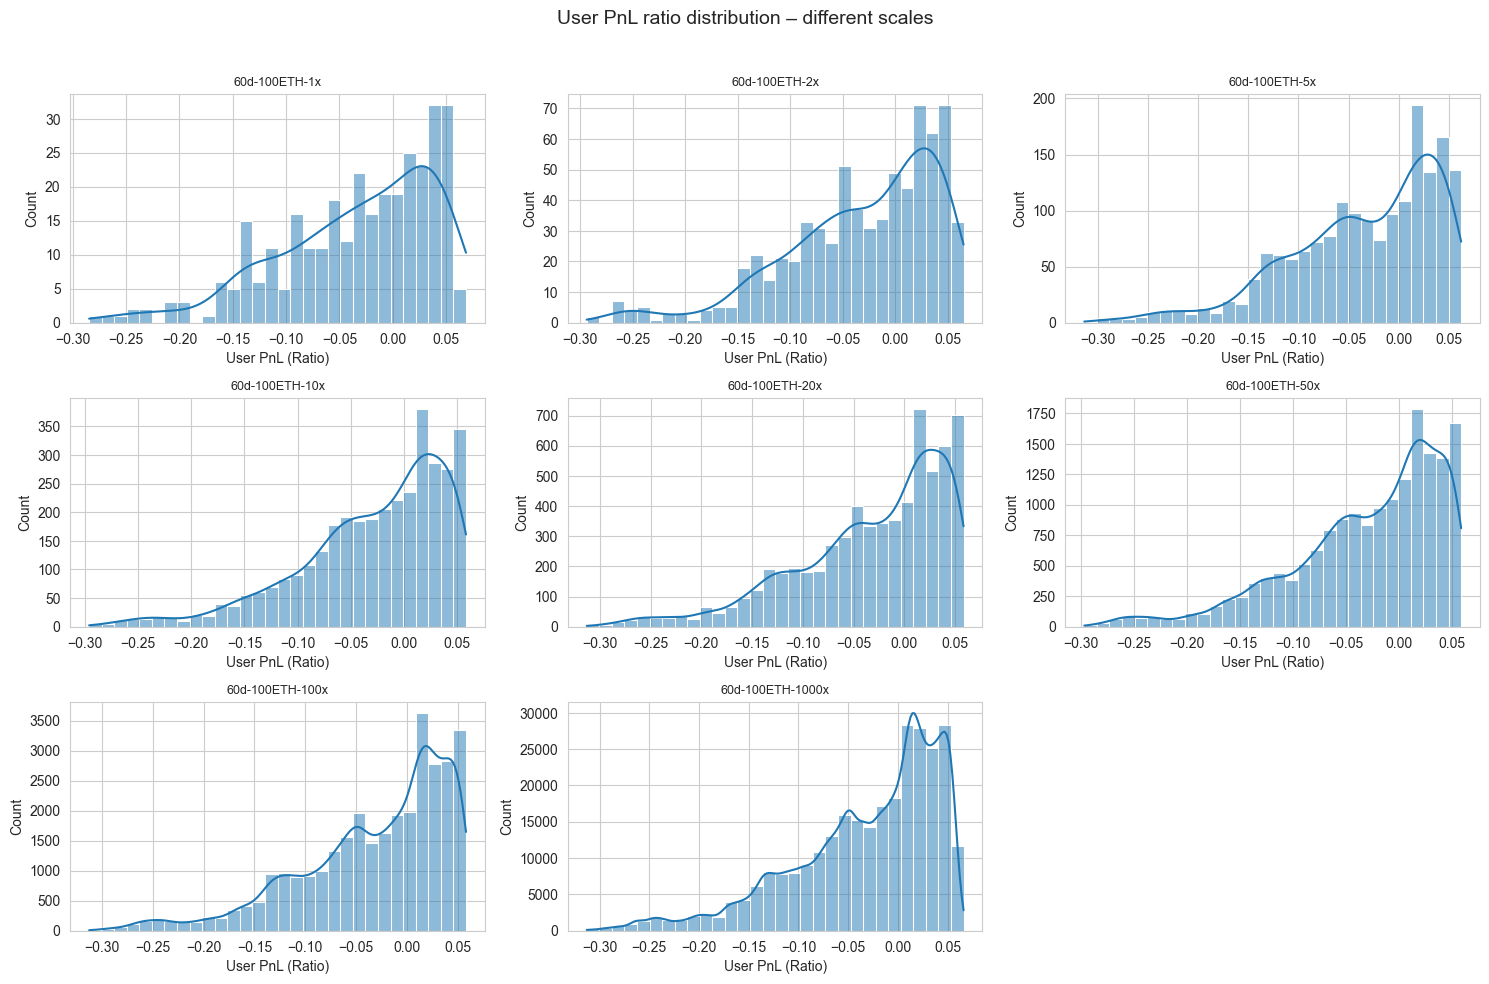

[compare] ✅ saved to results/_compare


In [1]:
import sys, pathlib; sys.path.append("backtest_module")
from backtest import BacktestRunner
from analyzer import Analyzer
from compare import compare_runs  


horizons = [60]
init_eths = [100]
SCALES = [1, 5, 10, 50]  # 想測的 x 倍率值
BASIS = 0.5
W_FACTOR = 1

results = {}  # {(h, init_eth): (dep, wd, snap, info)}

for h in horizons:
    for ie in init_eths:
        for scale in SCALES:
            runner = BacktestRunner(init_eth=ie, main_days=h, basis=BASIS, scale=scale)
            info = runner.get_info()
            tag = f"{h}d-{ie}ETH-x{scale} ({info['start_date']}~{info['total_end_date']})"

            dep_df, wd_df, snap_df = runner.run()
            results[(h, ie, scale)] = (dep_df, wd_df, snap_df, info)

            print(f"========= {tag} =========")
            print(f"info: {info}")
            print(f"deposits:{len(dep_df)}  withdraws:{len(wd_df)}")
            print(f"User PnL Total: {wd_df["pnl_usd"].sum()}, \n User PnL Average: {wd_df["pnl_usd"].mean()}")
            # 個別分析 & 存檔
            Analyzer(dep_df, wd_df, snap_df, tag).all_plots()

# ----------- ★ 產出總比較 ---------------
compare_runs(results)